# 0. Imports

### 0.1 Libs

In [375]:
import warnings
import inflection
import re
import datetime

import numpy    as np
import pandas   as pd
import seaborn  as sns
import nbformat
import umap.umap_ as umap


from IPython.display        import Image
from scipy                  import stats            as ss
from plotly                 import express          as px
from matplotlib             import pyplot           as plt
from sklearn                import cluster          as c
from sklearn                import metrics          as m
from sklearn                import preprocessing    as pp

from yellowbrick.cluster    import KElbowVisualizer, SilhouetteVisualizer

### 0.2 Helper Functions

In [376]:
warnings.simplefilter("ignore")

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    m.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return m

# Cramér's V
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values               
    n = cm.sum()                                 
    r, k = cm.shape                             
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )



### 0.3 Loading Data

In [377]:
df_raw = pd.read_csv('../data/data.csv', encoding= 'unicode_escape')

# 1. Data Description

### 1.0 Rename Columns

In [378]:
df1 = df_raw.copy()

df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [379]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.1 Data Dimentions

In [380]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


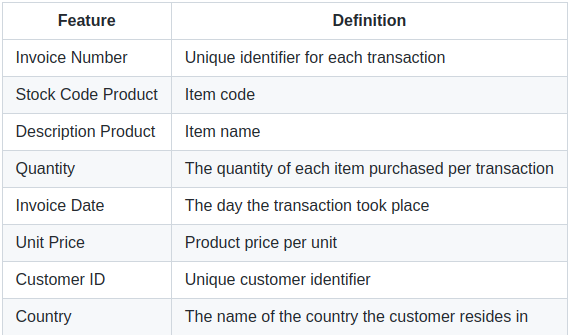

In [381]:
Image('../image/features_description.png')

### 1.2 Data Types

In [382]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3 Check NA

In [383]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.4 Fillout NA

In [384]:
# Para avançar com o projeto de forma rápida, vamos retirar os registros com valores faltantes. 
# Posteriormente serão analisadas outras possibilidades de tratar esses dados.

# df1 = df1.dropna(subset=['description', 'customer_id'])
# print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
# print(f'New number of rows: {df1.shape[0]}')

In [385]:
# Analise detalhada do Na

df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [386]:
# Tentativa 1: verificar se algum invoice_no está nos 2 datasets (df_missing e df_not_missing)
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
missing_invoice[0:10]

['536414',
 '536544',
 '536545',
 '536546',
 '536547',
 '536549',
 '536550',
 '536552',
 '536553',
 '536554']

In [387]:
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), : ]

# Nenhum resultado bateu...

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [388]:
# Tentativa 2: criar um id para os valores faltantes e assim não descartar as informações registradas

# create reference

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


# Merge with original dataframe
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# **Coalesce - função legal para aprender 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,17850.0


In [389]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.5 Change Types

In [390]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [391]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1['invoice_date'] = df1['invoice_date'].dt.strftime('%Y-%m-%d')

In [392]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


In [393]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.6 Descriptive Statistics

#### 1.6.0  Datasets

In [394]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])


#### 1.6.1 Nummerical Attributes

In [395]:
numerical_metrics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


<font color = 'red'> Attention Points </font>

1. Negative Quantity
2. Unit price equal zero

#### 1.6.2 Categorical Attributes

In [396]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


##### Invoice No

In [397]:
# The invoice_no should be a number
# df1['invoice_no'].astype(int) --> dá erro pois alguns registros possuem letras no código

# Quantidade de registros com letras
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

df_letter_invoice

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2010-12-01,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,United Kingdom,17548
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,United Kingdom,14397
541541,C581499,M,Manual,-1,2011-12-09,224.69,United Kingdom,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,United Kingdom,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,United Kingdom,17315


In [398]:
print(f'Total invoice_no with letter: {len(df_letter_invoice)}')
print('Total invoice_no with letter and negative quantity value: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity']<0])))

Total invoice_no with letter: 9291
Total invoice_no with letter and negative quantity value: 9288


##### Stock Code

In [399]:
# The stock_code should be a number
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2010-12-01,18.00,France,12583
141,C536379,D,Discount,-1,2010-12-01,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2010-12-01,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2010-12-01,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01,569.77,United Kingdom,19001
...,...,...,...,...,...,...,...,...
541540,581498,DOT,DOTCOM POSTAGE,1,2011-12-09,1714.17,United Kingdom,22709
541541,C581499,M,Manual,-1,2011-12-09,224.69,United Kingdom,15498
541730,581570,POST,POSTAGE,1,2011-12-09,18.00,Germany,12662
541767,581574,POST,POSTAGE,2,2011-12-09,18.00,Germany,12526


In [400]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# task: remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

##### Description

In [401]:
# Nesse ciclo a Description não parece ser importante para a melhoria do algoritmo

# Task: delete description

##### Country

In [402]:
len(df1['country'].unique())

38

In [403]:
df1['country'].value_counts(normalize = True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [404]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2. Data Filtering 

In [405]:
df2 = df1.copy()

In [406]:
# ==== Cat Attributes ====

# Stock Code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# Description
df2 = df2.drop(columns = 'description', axis = 1)

# Country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]


# ==== Num Attributes ====

# Unit Price > 0.04 
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Quantity
df_returns = df2.loc[df2['quantity']<0, :]
df_purchases = df2.loc[df2['quantity']>0, :]


# 3. Feature Engineering

### 3.1 Gross Revenue

In [407]:
df3 = df2.copy()

In [408]:
# Data Reference
df_ref = df3.drop (['invoice_no', 'stock_code',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)

In [409]:
# Monetary (Gross Revenue)
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge (df_ref, df_monetary, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.2 Recency - Day from last purchase

In [410]:
# Recency
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.3 Quantity of purchase

In [411]:
df_count = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_count, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
dtype: int64

### 3.4 Quantity of products purchased

In [412]:
df_prod = df_purchases[['customer_id', 'quantity']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_prod, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
quantity         91
dtype: int64

### 3.4 Average Ticket Value

In [413]:
# Avg Ticket
df_avg_ticket = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
quantity         91
avg_ticket       91
dtype: int64

### 3.5 Average Recency Days


In [414]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])

df_aux['previous_customer'] = df_aux['customer_id'].shift()
df_aux['previous_date']     = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['previous_customer'] else np.nan, axis=1)
df_aux = df_aux.drop(['invoice_date', 'previous_customer', 'previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on = 'customer_id', how = 'left')
df_ref.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
quantity              91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.6 Frequency Purchase

In [415]:
df_aux = (df3[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_    = ('invoice_date', 'max'),
                                                                 min_    = ('invoice_date', 'min'),
                                                                 days_   = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                 buy_    = ('invoice_no', 'count') ) ).reset_index()

df_aux.head()

,customer_id,max_,min_,days_,buy_
0,12346,2011-01-18,2011-01-18,1,2
1,12347,2011-12-07,2010-12-07,366,7
2,12348,2011-09-25,2010-12-16,284,4
3,12349,2011-11-21,2011-11-21,1,1
4,12350,2011-02-02,2011-02-02,1,1


In [416]:
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)
df_aux.head(10)

,customer_id,max_,min_,days_,buy_,frequency
0,12346,2011-01-18,2011-01-18,1,2,2.000000
1,12347,2011-12-07,2010-12-07,366,7,0.019126
2,12348,2011-09-25,2010-12-16,284,4,0.014085
3,12349,2011-11-21,2011-11-21,1,1,1.000000
4,12350,2011-02-02,2011-02-02,1,1,1.000000
5,12352,2011-11-03,2011-02-16,261,8,0.030651
6,12353,2011-05-19,2011-05-19,1,1,1.000000
7,12354,2011-04-21,2011-04-21,1,1,1.000000
8,12355,2011-05-09,2011-05-09,1,1,1.000000
9,12356,2011-11-17,2011-01-18,304,3,0.009868


In [417]:
# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
quantity              91
avg_ticket            91
avg_recency_days    2816
frequency              0
dtype: int64

### 3.7 Returns

In [418]:
df_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
154,C536383,35004C,-1,2010-12-01,4.65,United Kingdom,15311
235,C536391,22556,-12,2010-12-01,1.65,United Kingdom,17548
236,C536391,21984,-24,2010-12-01,0.29,United Kingdom,17548
237,C536391,21983,-24,2010-12-01,0.29,United Kingdom,17548
238,C536391,21980,-24,2010-12-01,0.29,United Kingdom,17548


In [419]:
# Return Number
df_returns = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity' : 'returns'})
df_returns['returns'] = df_returns['returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how = 'left', on='customer_id')

df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
quantity              91
avg_ticket            91
avg_recency_days    2816
frequency              0
returns                0
dtype: int64

### 3.8 Basket Size - quantidade de itens por cesta

In [420]:
df_aux = (df_purchases.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                       .agg(
                                                                          n_purchases = ('invoice_no', 'nunique'),
                                                                          n_products = ('quantity', 'sum') ).reset_index() )   

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_aux.head()

,customer_id,n_purchases,n_products,avg_basket_size
0,12346,1,74215,74215.000000
1,12347,7,2458,351.142857
2,12348,4,2332,583.000000
3,12349,1,630,630.000000
4,12350,1,196,196.000000


In [421]:
# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on = 'customer_id', how = 'left')
df_ref.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
quantity              91
avg_ticket            91
avg_recency_days    2816
frequency              0
returns                0
avg_basket_size       91
dtype: int64

### 3.9 Unique Basket Size - quantidade de produtos distintos por compra

In [422]:
df_aux = (df_purchases.loc[:,['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg(
                                                                          n_purchases = ('invoice_no', 'nunique'),
                                                                          n_products = ('stock_code', 'count') ).reset_index() )   

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']
df_aux.head()

,customer_id,n_purchases,n_products,avg_unique_basket_size
0,12346,1,1,1.00
1,12347,7,182,26.00
2,12348,4,27,6.75
3,12349,1,72,72.00
4,12350,1,16,16.00


In [423]:
# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
invoice_no                  91
quantity                    91
avg_ticket                  91
avg_recency_days          2816
frequency                    0
returns                      0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [424]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,6.0,18.152222,35.500000,0.486111,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,11.0,18.904035,27.250000,0.048780,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,24.0,28.902500,23.187500,0.045699,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,8.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,2.0,292.000000,8.600000,0.136364,22.0,26.666667,1.000000


# 4. Exploratory Data Analysis

In [425]:
df4 = df_ref.dropna().copy()

df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
invoice_no                0
quantity                  0
avg_ticket                0
avg_recency_days          0
frequency                 0
returns                   0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

# 5. Data Preparation

In [ ]:
df5 = df4.copy()

df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,returns
0,17850,5391.21,372.0,34.0,6.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,11.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,24.0,28.902500,2.0
3,13748,948.25,95.0,5.0,8.0,33.866071,0.0
4,15100,876.00,333.0,3.0,2.0,292.000000,3.0


In [ ]:
# Standatization

ss = pp.StandardScaler()

df5['gross_revenue']    = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days']     = ss.fit_transform(df5[['recency_days']])
df5['invoice_no']       = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket']       = ss.fit_transform(df5[['avg_ticket']])
df5['returns']          = ss.fit_transform(df5[['returns']])


# 6. Feature Selection

In [ ]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

### 7.0 Dataset

In [ ]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,returns
0,17850,0.454360,2.285010,4.481562,6.0,-0.028444,0.235215
1,13047,0.180979,-0.545579,0.811636,11.0,-0.027857,3.663238
2,12583,0.620794,-1.029288,1.692418,24.0,-0.020054,0.806552
3,13748,-0.108323,-0.196234,0.224448,8.0,-0.016180,-0.336122
4,15100,-0.117473,1.935665,-0.069146,2.0,0.185277,1.377890


In [ ]:
df7 = df6.drop(columns = ['customer_id'])

### 7.1 Within-Cluster Sum of Square (WSS)

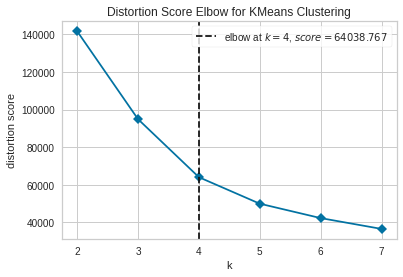

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
clusters = [2, 3, 4, 5, 6, 7]

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          timings = False)
# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.2 Silhouette Score

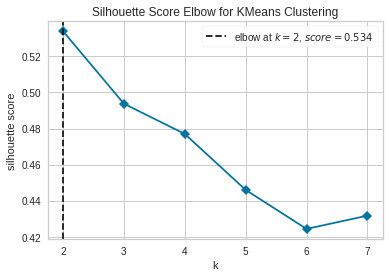

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
# Yellow Brick

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          metric='silhouette',
                          timings = False)

# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.3 Silhouette Analysis

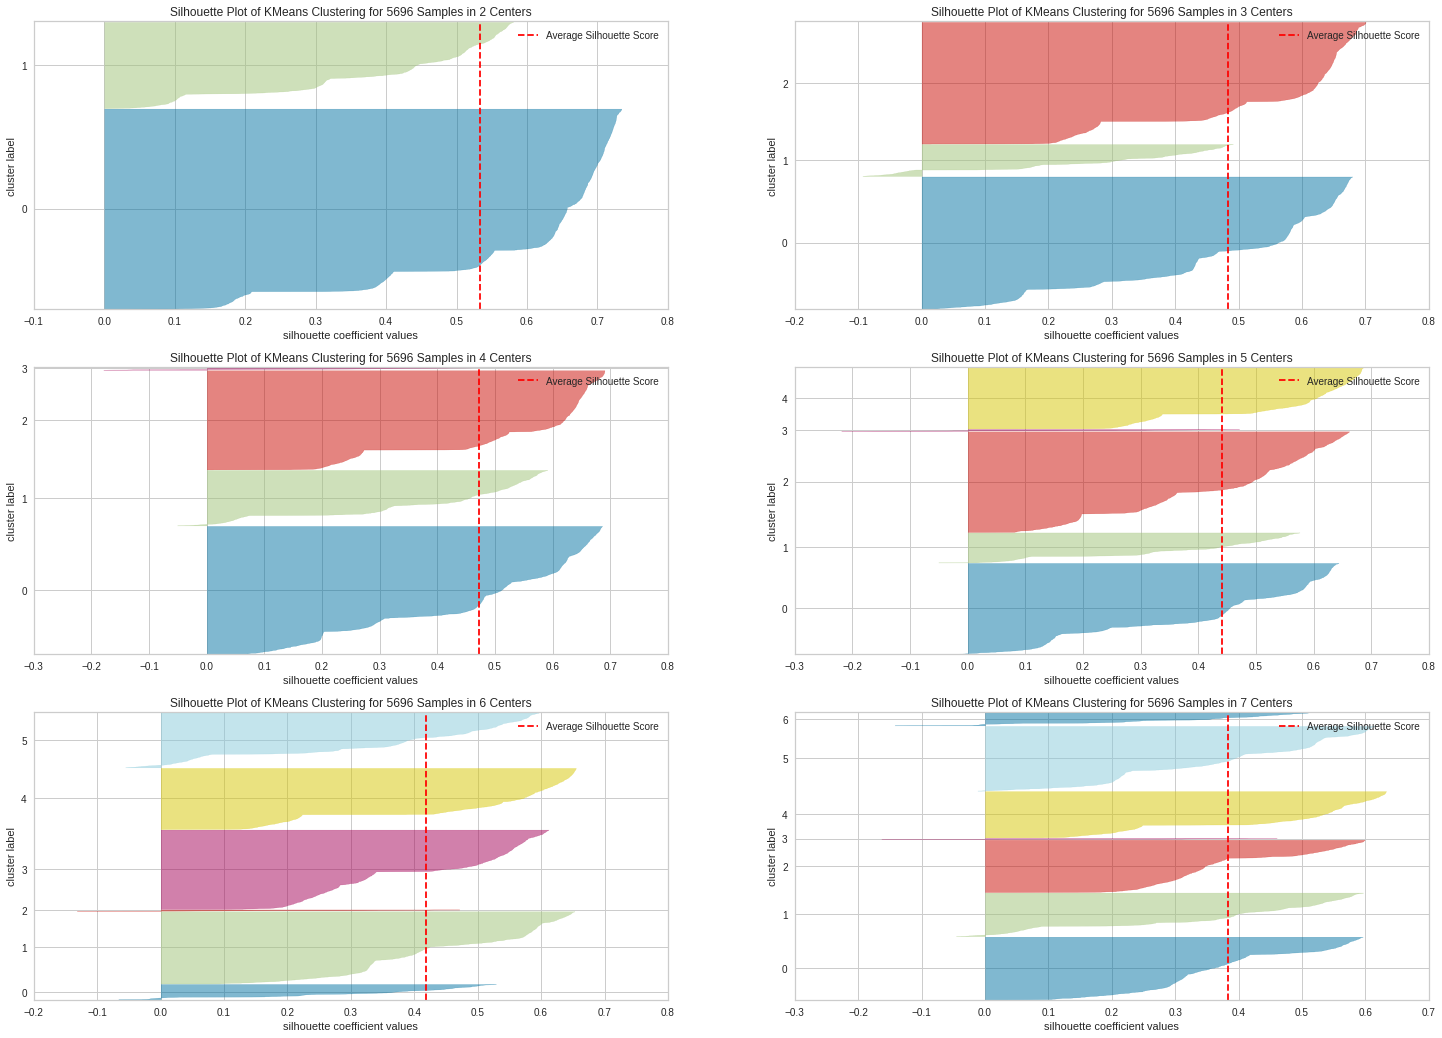

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k,
                    init='random',
                    n_init=10,
                    max_iter=100,
                    random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

# 8. Machine Learning Modelling

### 8.1 K-Means

In [ ]:
X = df7.copy()

In [ ]:
# model definition
k=3
kmeans = c.KMeans(init='random',
                  n_clusters=k,
                  n_init=10,
                  max_iter=300,
                  random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [ ]:
# WSS
print(f'WSS Value:{kmeans.inertia_}')

# SS
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Value:96187.63061795282
SS Value: 0.4827346842278374


# 9. Evaluation - Cluster Analysis

### 9.1 Visualization Inspection

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,returns,cluster
0,17850,0.454360,2.285010,4.481562,6.0,-0.028444,0.235215,2
1,13047,0.180979,-0.545579,0.811636,11.0,-0.027857,3.663238,0
2,12583,0.620794,-1.029288,1.692418,24.0,-0.020054,0.806552,1
3,13748,-0.108323,-0.196234,0.224448,8.0,-0.016180,-0.336122,0
4,15100,-0.117473,1.935665,-0.069146,2.0,0.185277,1.377890,2


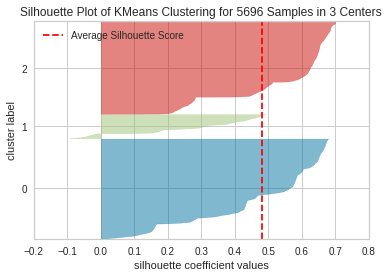

In [ ]:
# Silhouette Viz:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

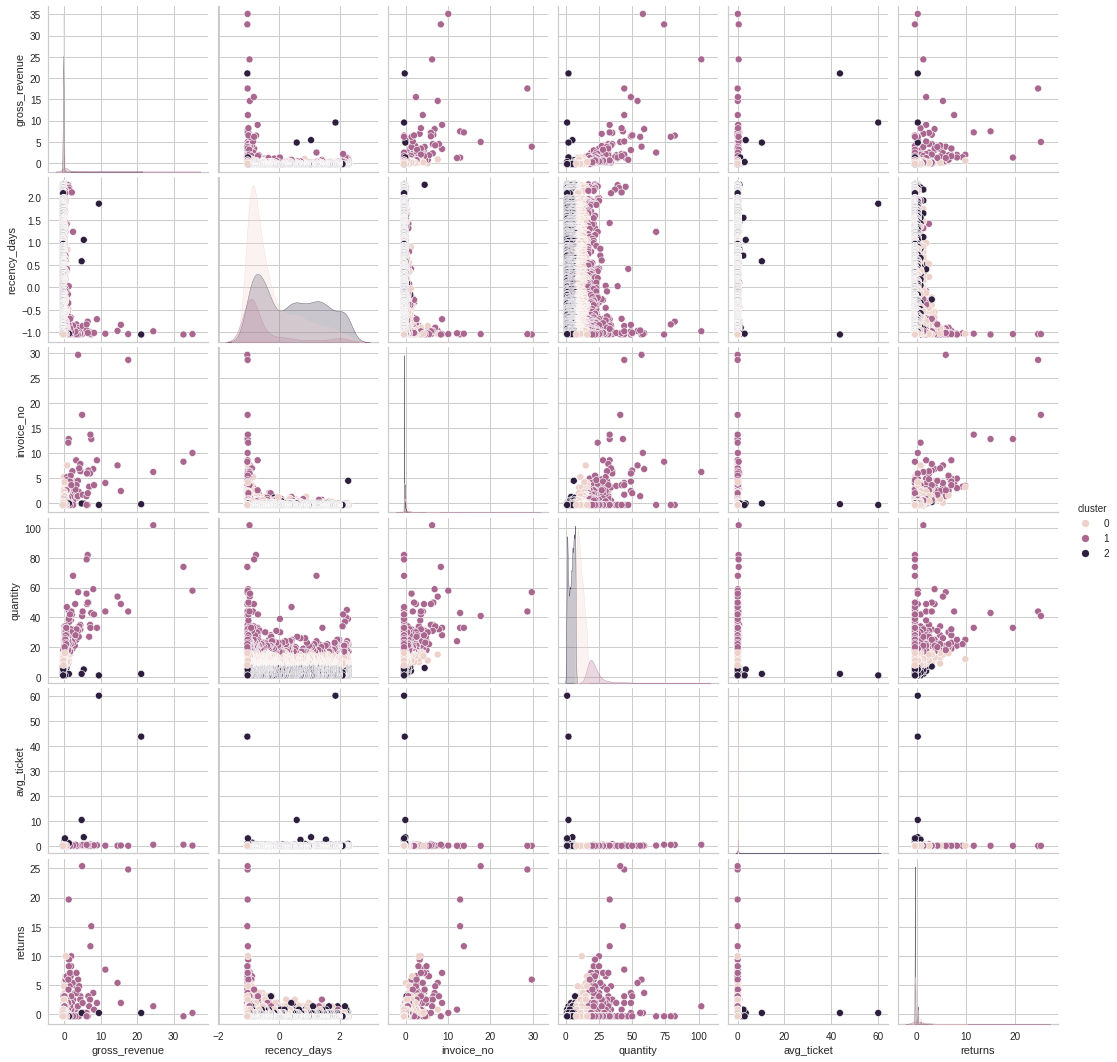

In [ ]:
# 2D Plot (Pair Plot)
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

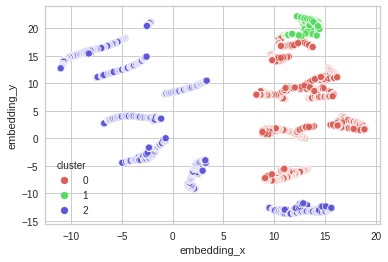

In [ ]:
# UMAP (mais rápido para grandes quantidades de dados) / t-SNE (mais preciso, porém mais lento): 
    # abordagem por Manifold (topologia) - projeção de altas dimensões em 3D ou 2D sem perder suas características principais

reducer = umap.UMAP(n_neighbors=40, random_state=42)
embedding = reducer.fit_transform (X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data = df_viz)

### 9.2 Cluster Profile

In [ ]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,returns,cluster
0,17850,0.454360,2.285010,4.481562,6.0,-0.028444,0.235215,2
1,13047,0.180979,-0.545579,0.811636,11.0,-0.027857,3.663238,0
2,12583,0.620794,-1.029288,1.692418,24.0,-0.020054,0.806552,1
3,13748,-0.108323,-0.196234,0.224448,8.0,-0.016180,-0.336122,0
4,15100,-0.117473,1.935665,-0.069146,2.0,0.185277,1.377890,2


In [ ]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on = 'cluster')

# Avg recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')


df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,2634,46.242978,-0.050220,-0.264821,0.023536,-0.027938
1,1,636,11.165730,0.860736,-0.483045,1.057914,-0.014132
2,2,2426,42.591292,-0.171124,0.414161,-0.302896,0.034038


Cluster 01 (Candidado a Insider):
- Total Customers: 6 (0,14% of total)
- Avg Recency: 7 days
- Avg frequency: 89 purchase
- Avg Revenue: $ 182,181.98

Cluster 02:
- Total Customers: 31 (0,71% of total)
- Avg Recency: 14 days
- Avg frequency: 53 purchase
- Avg Revenue: $ 40,543.52

Cluster 03:
- Total Customers: 4,335 (99% of total)
- Avg Recency: 92 days
- Avg frequency: 5 purchase
- Avg Revenue: $ 1,372.58

# 10. Deploy To Production